# Hello Network Analysis!

Date created: March 27, 2024

Author: Jonathan Bui

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

- get a list of all the proteins seen in a dataset
- filter the STRING network to only contain proteins seen in that dataset
- load the smaller graph in NetworkX
- perform ??? analysis, look up tutorials

In [2]:
pg_matrix = pd.read_csv("data/PXD047236_DIANN_report.pg_matrix.tsv", sep="\t")
pg_matrix.head()

,Protein.Group,Protein.Ids,Protein.Names,Genes,First.Protein.Description,1Y6.mzML,1Y9.mzML,1Y14.mzML,2Y2.mzML,2Y9.mzML,...,2Y8.mzML,1W7.mzML,1W11.mzML,2W6.mzML,1Y2.mzML,2Y14.mzML,2Y7.mzML,1W13.mzML,2W15.mzML,2W3.mzML
0,A0A075B6H7;A0A0C4DH55,P01624;A0A075B6H7;A0A0C4DH55,KV37_HUMAN;KVD07_HUMAN,IGKV3-7;IGKV3D-7,NaN,5360000.0,4440000.0,3280000.0,2090000.0,3990000.00,...,4020000.0,4330000.0,3070000.0,15300000.0,6480000.0,1840000.0,1600000.0,3170000.0,4780000.0,2440000.0
1,A0A075B6I0,A0A075B6I0,LV861_HUMAN,IGLV8-61,NaN,220297.0,84993.6,188674.0,48123.3,78052.70,...,50566.2,62810.8,608445.0,69480.7,NaN,201605.0,32804.6,NaN,290068.0,381436.0
2,A0A075B6I9,A0A075B6I9,LV746_HUMAN,IGLV7-46,NaN,14661.2,NaN,10053.2,NaN,3168.52,...,29221.7,15855.0,NaN,19316.9,NaN,NaN,NaN,13356.0,NaN,24585.1
3,A0A075B6I9;P04211,P04211;A0A075B6I9,LV743_HUMAN;LV746_HUMAN,IGLV7-43;IGLV7-46,NaN,70729.0,337457.0,93126.2,820218.0,74922.70,...,693517.0,606087.0,116589.0,1500000.0,198801.0,265399.0,48102.3,913847.0,261519.0,950739.0
4,A0A075B6J9,A0A075B6J9,LV218_HUMAN,IGLV2-18,NaN,NaN,NaN,17325.4,NaN,NaN,...,12767.3,20333.4,NaN,NaN,NaN,NaN,NaN,12879.2,NaN,NaN


In [3]:
full_network = pd.read_csv("data/string/9606.protein.physical.links.v12.0.txt", sep=" ")
full_network.head()

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000257770,311
1,9606.ENSP00000000233,9606.ENSP00000226004,161
2,9606.ENSP00000000233,9606.ENSP00000434442,499
3,9606.ENSP00000000233,9606.ENSP00000262455,531
4,9606.ENSP00000000233,9606.ENSP00000303145,499


The DIA-NN data uses UniProt protein accessions because the spectral library was derived from protein sequences in the UniProt database, and STRING uses its own protein IDs.

The [UniProt ID mapping tool](https://www.uniprot.org/id-mapping) is useful for this scenario and can generate a 1-to-1 mapping of protein IDs between each database. In this case, the id-mapping job was submitted manually through a web interface, but this task can also be achieved programmatically on the command-line (see [UniProt documentation](https://www.uniprot.org/help/id_mapping)).

In [4]:
id_mapping_result = pd.read_csv("data/idmapping_2024_03_27.tsv", sep="\t")
id_mapping_result.head()

,From,To
0,A0A075B6S2,9606.ENSP00000483567
1,A0A0B4J1V0,9606.ENSP00000479675
2,A0A0B4J1Y9,9606.ENSP00000480035
3,A0A0C4DH29,9606.ENSP00000479119
4,A0A1W2PQ73,9606.ENSP00000491574


In [5]:
# filter the network edges to contain only proteins that exist in the dataset
# could also choose to include proteins one degree away from the observed network of proteins, but I want to start with the smallest network
observed_network = full_network[full_network["protein1"].isin(id_mapping_result.To)]
observed_network = observed_network[observed_network["protein2"].isin(id_mapping_result.To)]
observed_network

,protein1,protein2,combined_score
475,9606.ENSP00000002165,9606.ENSP00000324173,191
482,9606.ENSP00000002165,9606.ENSP00000322323,499
492,9606.ENSP00000002165,9606.ENSP00000285599,240
494,9606.ENSP00000002165,9606.ENSP00000363603,916
495,9606.ENSP00000002165,9606.ENSP00000247461,330
...,...,...,...
1476677,9606.ENSP00000500990,9606.ENSP00000315130,603
1476679,9606.ENSP00000500990,9606.ENSP00000302961,929
1476695,9606.ENSP00000500990,9606.ENSP00000299767,373
1476707,9606.ENSP00000500990,9606.ENSP00000256637,165


In [6]:
# arbitrarily filter for confident interactions
observed_network = observed_network[observed_network["combined_score"] >= 700]

In [7]:
# get nodes
nodes = pd.Series(observed_network["protein1"].values, observed_network["protein2"].values).unique()
nodes[:5]

array(['9606.ENSP00000002165', '9606.ENSP00000002829',
       '9606.ENSP00000005587', '9606.ENSP00000008938',
       '9606.ENSP00000011292'], dtype=object)

In [8]:
# TODO: preserve weights (combined_score confidence)
edges = list(zip(observed_network["protein1"].values, observed_network["protein2"].values))
edges[:5]

[('9606.ENSP00000002165', '9606.ENSP00000363603'),
 ('9606.ENSP00000002829', '9606.ENSP00000377061'),
 ('9606.ENSP00000002829', '9606.ENSP00000265371'),
 ('9606.ENSP00000002829', '9606.ENSP00000353582'),
 ('9606.ENSP00000005587', '9606.ENSP00000379350')]

In [9]:
# loop thrugh the dataframe to construct the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

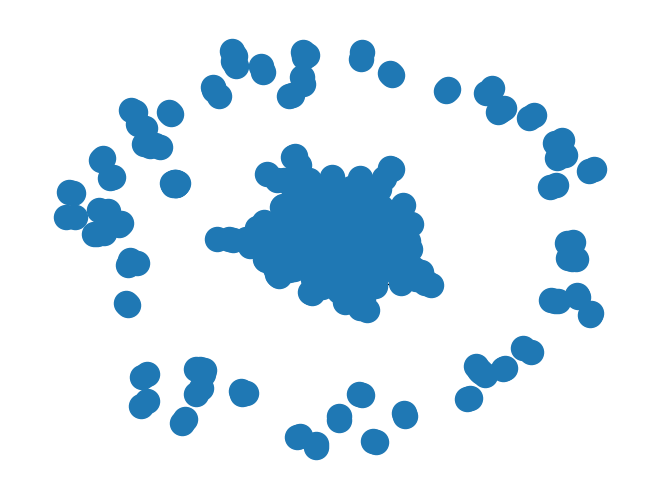

In [10]:
nx.draw(G, with_labels=False, font_weight='bold')

### Brainstorming potential graph analyses

This is a protein-protein interaction network.

Useful additional data that could help me ask questions about specific proteins:

- differentially expressed proteins
- predictive proteins (i.e. potential biomarkers) for a disease
- proteins that are seen only seen specifically in one group or another group of an analysis

However, if I already had the above information, it follows that this network analysis comes *after* all existing bioinformatics analyses, so this network would serve to supplement those results.

Are there questions that can be answered via an unbiased analysis from a small network of observed proteins in a dataset? What are common graph analysis methods?

- which groups of proteins form a sub-graph that is independent / disconnected from the rest of the proteome?
    - I can't think of why a wholly disconnected protein with 0 interactions would be interesting, but I do think maybe protein subgraphs of around 5-10 members might be interesting
    - Follow up this analysis with "why would these proteins matter" by performing a GO / KEGG / reactome analysis?
- What is the shortest simple path through the network (but how to choose start / end points?)
- What is the most influential protein in the graph (centrality analysis)?
    - Centrality analysis may be improved by adding edge weights. Potential ideas for weights: "combined_score" (confidence) of the interaction, "correlation" between connected members,
    - Is there any reason to add weighted nodes? Perhaps, by weighting nodes by missingness, e.g. proteins seen in more samples have higher weight than proteins that are rarely seen, or the inverse (find the most influential protein that is rarely seen)
 
### Centrality analysis

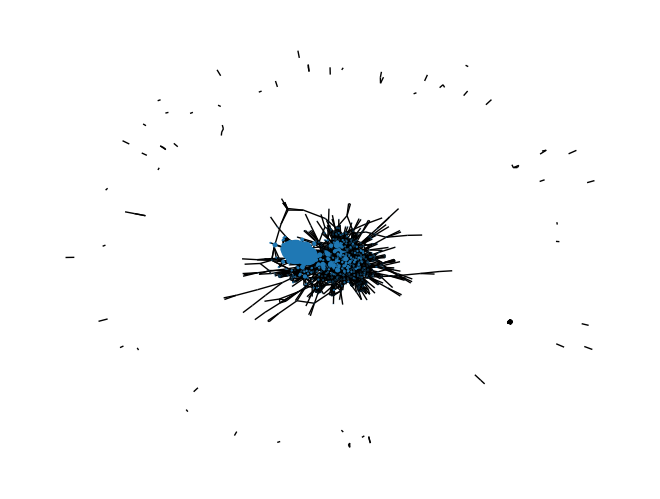

In [15]:
# TODO try centrality analysis
# identify centrality of each node
centrality=nx.eigenvector_centrality(G)
nx.set_node_attributes(G, centrality, "eigenvector")
# size nodes by centrality
node_size = [v * 1000 for v in nx.get_node_attributes(G, 'eigenvector').values()]
nx.draw(G, node_size= node_size, with_labels=False)

In [30]:
df_centrality = pd.DataFrame.from_dict(centrality, orient="index", columns=["eigenvector_centrality"])
central_proteins = df_centrality.eigenvector_centrality.nlargest(10).index

# the 10 most central interacting proteins in the proteome are ribosomal proteins... 
# not surprising because every protein needs to get translated, duh
id_mapping_result[id_mapping_result["To"].isin(central_proteins)]

,From,To
359,P08865,9606.ENSP00000389351
486,P15880,9606.ENSP00000341885
576,P23396,9606.ENSP00000278572
733,P46783,9606.ENSP00000481646
836,P61247,9606.ENSP00000346050
846,P62081,9606.ENSP00000495273
849,P62266,9606.ENSP00000296674
850,P62277,9606.ENSP00000435777
851,P62280,9606.ENSP00000270625
854,P62701,9606.ENSP00000362744


## Other ways to construct a network

Although this notebook only briefly examined a protein-protein interaction network, there are many other ways to define edges in the graph. Using protein-protein interaction information as graph edges happens to be a commonly used method based on curated information. There are many examples of protein-protein interaction analyses, and the STRING database has an idea

Monica used a different method to connect proteins into a network, which did not depend on data curation: she connected proteins based on co-expression information, as calculated by a positive or negative correlation in protein intensities. Proteins correlating above a specific threshold are connected by an edge.

What other methods are used? From the literature:

- TODO find papers that use graph analysis